In this script I'll build the ANN for a classification

In [63]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import sklearn.metrics as metrics 
import keras_tuner as kt
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import time
import h5py

In [3]:
fetal_data = pd.read_csv("in/fetal_health.csv")
fetal_data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,132,0.006,0.000,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
1,133,0.003,0.000,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
2,134,0.003,0.000,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
3,132,0.007,0.000,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1
4,131,0.005,0.072,0.008,0.003,0.0,0.0,28,1.4,0,...,88,154,5,0,135,134,137,7,1,1


In [4]:
fetal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2597 non-null   int64  
 1   accelerations                                           2597 non-null   float64
 2   fetal_movement                                          2597 non-null   float64
 3   uterine_contractions                                    2597 non-null   float64
 4   light_decelerations                                     2597 non-null   float64
 5   severe_decelerations                                    2597 non-null   float64
 6   prolongued_decelerations                                2597 non-null   float64
 7   abnormal_short_term_variability                         2597 non-null   int64  
 8   mean_value_of_short_term_variability  

In [5]:
# Are the clases unbalanced? / Yes They are.
fetal_data.groupby("fetal_health").size()

fetal_health
1    1655
2     590
3     352
dtype: int64

Because of unbalanced data. The test/val size will be (5% for each one)

In [6]:
# Spliting data into features and labels
X = fetal_data.iloc[:,1:21]#.values
y = fetal_data["fetal_health"].astype(int)#.values

# Spliting the dataset into train, test and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 0)
abs_test_size = int(round(X.shape[0]*0.05,0))

# Split Train between train and validate / 268 is the 20% of the balanced dataset
X_val = X_train[:abs_test_size]
partial_X_train = X_train[abs_test_size:]

y_val = y_train[:abs_test_size]
partial_y_train = y_train[abs_test_size:]

# # Length
print('# Train:', partial_X_train.shape[0])
print('# Val:', X_val.shape[0])
print('# Test:', X_test.shape[0])

# Train: 2337
# Val: 130
# Test: 130


C:\Users\elvie\AppData\Local\Temp\ipykernel_11792\202329958.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_val = y_train[:abs_test_size]
C:\Users\elvie\AppData\Local\Temp\ipykernel_11792\202329958.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  partial_y_train = y_train[abs_test_size:]


In [7]:
# Are the train clases unbalanced? / Yes They are.
unbalanced_train = pd.DataFrame.copy(partial_X_train)
unbalanced_train["fetal_health"] = partial_y_train
unbalanced_train.groupby("fetal_health").size()

fetal_health
1    1499
2     517
3     321
dtype: int64

In [8]:
undersample = RandomUnderSampler(random_state=42)
X_train_bal, y_Train_bal = undersample.fit_resample(partial_X_train, partial_y_train)
print(y_Train_bal)

0      1
1      1
2      1
3      1
4      1
      ..
958    3
959    3
960    3
961    3
962    3
Name: fetal_health, Length: 963, dtype: int32


In [9]:
balanced_train = pd.DataFrame.copy(X_train_bal)
balanced_train["fetal_health"] = y_Train_bal.astype(int)
balanced_train.groupby("fetal_health").size()

fetal_health
1    321
2    321
3    321
dtype: int64

The amount of data is not much, so It's necessary to take this into account when the ANN classifier will be built.

Now, let's continue with the feature engineering part.

In [10]:
y_val[2490]

3

In [11]:
# Applying one-hot-econding method to the labels (y)
y_train_onehot = to_categorical(y_Train_bal)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Print
print('Train labels example:', y_train_onehot[0], "is equal to:", y_Train_bal[0])
print('Val labels example:', y_val_onehot[0], "is equal to:", y_val[2490])
print('Test labels example:', y_test_onehot[0], "is equal to:", y_test[182])

Train labels example: [0. 1. 0. 0.] is equal to: 1
Val labels example: [0. 0. 0. 1.] is equal to: 3
Test labels example: [0. 1. 0. 0.] is equal to: 1


In [12]:
# PCA to features (X)
pca = PCA(n_components=4)  
pca.fit(X_train_bal)


PCA(n_components=4)

In [13]:
# Number of information that contribute each component.
pca.explained_variance_ratio_ 
print("Four of twenty components contribute to: ", round((sum(pca.explained_variance_ratio_ )*100),2),"%")

Four of twenty components contribute to:  94.03 %


In [14]:
# Apply the PCA to all X features
dt_train = pca.transform(X_train_bal)
dt_test = pca.transform(X_test)
dt_val = pca.transform(X_val)

In [15]:
dt_train.shape

(963, 4)

In [25]:
# Building the ANN v 1.0
Model_1 = Sequential()
Model_1.add(Dense(64, activation='relu', input_shape=(4,)))
Model_1.add(Dense(128, activation='relu'))
Model_1.add(Dense(256, activation='relu'))
Model_1.add(Dense(512, activation='relu'))
Model_1.add(Dense(4, activation='softmax'))

Model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                320       
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dense_13 (Dense)            (None, 512)               131584    
                                                                 
 dense_14 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 175,300
Trainable params: 175,300
Non-trainable params: 0
_________________________________________________________________


In [26]:
Model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [27]:
Hist_1 = Model_1.fit(dt_train,
                   y_train_onehot,
                   epochs=100,
                   batch_size=512,
                   validation_data=(dt_val, y_val_onehot))

Epoch 1/100
2/2 [==============================] - 1s 246ms/step - loss: 2.9544 - acc: 0.2316 - val_loss: 2.2585 - val_acc: 0.7538
Epoch 2/100
2/2 [==============================] - 0s 49ms/step - loss: 3.0559 - acc: 0.6231 - val_loss: 1.5893 - val_acc: 0.6462
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 1.5484 - acc: 0.6033 - val_loss: 0.9624 - val_acc: 0.7385
Epoch 4/100
2/2 [==============================] - 0s 51ms/step - loss: 0.8463 - acc: 0.7207 - val_loss: 0.6888 - val_acc: 0.7615
Epoch 5/100
2/2 [==============================] - 0s 50ms/step - loss: 0.5479 - acc: 0.7954 - val_loss: 0.5724 - val_acc: 0.8385
Epoch 6/100
2/2 [==============================] - 0s 51ms/step - loss: 0.4933 - acc: 0.8100 - val_loss: 0.5661 - val_acc: 0.8154
Epoch 7/100
2/2 [==============================] - 0s 46ms/step - loss: 0.4614 - acc: 0.8255 - val_loss: 0.5470 - val_acc: 0.8231
Epoch 8/100
2/2 [==============================] - 0s 44ms/step - loss: 0.4522 - acc: 0.8

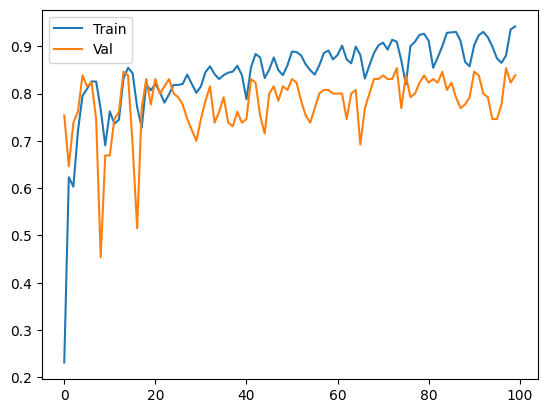

In [28]:
# Checking the overfitting
plt.plot(Hist_1.history['acc'], label='Train')
plt.plot(Hist_1.history['val_acc'], label='Val')
plt.legend()
plt.show()

In [29]:
# Evaluate with test
Model_1.evaluate(dt_test, y_test_onehot)

5/5 [==============================] - 0s 3ms/step - loss: 0.4933 - acc: 0.8692


[0.49333682656288147, 0.8692307472229004]

In [31]:
# Predict
prediction_1 = Model_1.predict(dt_test)
print(np.argmax(prediction_1[50]))
print(y_test_onehot[50])

5/5 [==============================] - 0s 2ms/step
2
[0. 0. 1. 0.]


The first ANN classifier model was built. In this case, it has a great accuracy, but it seems there's a small overfitting. So, let's train a second model with some regularization methods.

In [52]:
# Building the ANN v 2.0 with regularizers
Model_2 = Sequential()
Model_2.add(Dense(64, activation='relu', input_shape=(4,), kernel_regularizer=regularizers.l2(1e-4)))
Model_2.add(Dense(128, activation='relu'))
Model_2.add(Dropout(0.2))
Model_2.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
Model_2.add(Dense(512, activation='relu'))
Model_2.add(Dropout(0.2))
Model_2.add(Dense(4, activation='softmax'))

Model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 64)                320       
                                                                 
 dense_51 (Dense)            (None, 128)               8320      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               33024     
                                                                 
 dense_53 (Dense)            (None, 512)               131584    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_54 (Dense)            (None, 4)               

In [53]:
Model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Hist_2 = Model_2.fit(dt_train,
                   y_train_onehot,
                   epochs=400,
                   batch_size=512,
                   validation_data=(dt_val, y_val_onehot))

Epoch 1/400
2/2 [==============================] - 1s 242ms/step - loss: 6.3377 - acc: 0.3769 - val_loss: 2.5784 - val_acc: 0.6154
Epoch 2/400
2/2 [==============================] - 0s 46ms/step - loss: 3.1147 - acc: 0.5171 - val_loss: 1.0147 - val_acc: 0.7462
Epoch 3/400
2/2 [==============================] - 0s 50ms/step - loss: 0.9870 - acc: 0.7321 - val_loss: 0.9488 - val_acc: 0.6615
Epoch 4/400
2/2 [==============================] - 0s 52ms/step - loss: 1.0267 - acc: 0.6843 - val_loss: 0.8414 - val_acc: 0.6923
Epoch 5/400
2/2 [==============================] - 0s 54ms/step - loss: 0.7893 - acc: 0.7331 - val_loss: 0.6144 - val_acc: 0.8077
Epoch 6/400
2/2 [==============================] - 0s 52ms/step - loss: 0.7153 - acc: 0.7497 - val_loss: 0.5777 - val_acc: 0.8077
Epoch 7/400
2/2 [==============================] - 0s 49ms/step - loss: 0.6413 - acc: 0.7518 - val_loss: 0.5356 - val_acc: 0.8231
Epoch 8/400
2/2 [==============================] - 0s 49ms/step - loss: 0.6900 - acc: 0.7

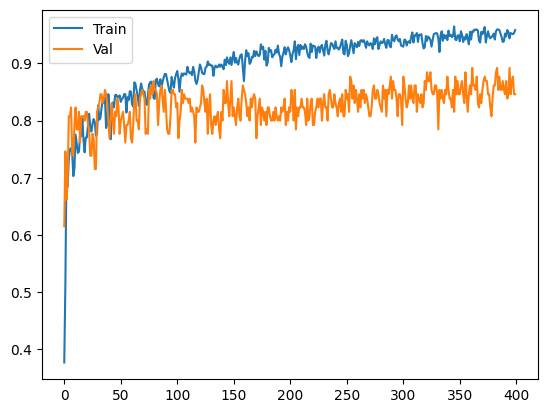

In [54]:
# Checking the overfitting
plt.plot(Hist_2.history['acc'], label='Train')
plt.plot(Hist_2.history['val_acc'], label='Val')
plt.legend()
plt.show()

In [55]:
# Evaluate with test
Model_2.evaluate(dt_test, y_test_onehot)

5/5 [==============================] - 0s 3ms/step - loss: 0.9686 - acc: 0.8615


[0.9686059355735779, 0.8615384697914124]

The seconde model got a better performances than the first one. But, due to the number of epochs the model was overtrained. So, let's work with callbacks on this second model to avoid overtraining the model.

In [60]:
# Building the ANN v 3.0 (the same scturcture as V2.0)
Model_3 = Sequential()
Model_3.add(Dense(64, activation='relu', input_shape=(4,), kernel_regularizer=regularizers.l2(1e-4)))
Model_3.add(Dense(128, activation='relu'))
Model_3.add(Dropout(0.2))
Model_3.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
Model_3.add(Dense(512, activation='relu'))
Model_3.add(Dropout(0.2))
Model_3.add(Dense(4, activation='softmax'))

#Model_3.summary()

# Call Back Early Stopping
callback_early = EarlyStopping(monitor = "val_acc", patience=30, mode = "auto")

# Compile and Train the model
Model_3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Hist_3 = Model_3.fit(dt_train,
                   y_train_onehot,
                   epochs=500,
                   batch_size=512,
                   callbacks = [callback_early],
                   validation_data=(dt_val, y_val_onehot))

Epoch 1/500
2/2 [==============================] - 1s 299ms/step - loss: 3.3614 - acc: 0.2928 - val_loss: 1.6013 - val_acc: 0.6231
Epoch 2/500
2/2 [==============================] - 0s 54ms/step - loss: 2.4462 - acc: 0.5254 - val_loss: 1.4480 - val_acc: 0.6231
Epoch 3/500
2/2 [==============================] - 0s 51ms/step - loss: 1.3678 - acc: 0.6490 - val_loss: 1.1156 - val_acc: 0.5923
Epoch 4/500
2/2 [==============================] - 0s 50ms/step - loss: 0.9667 - acc: 0.6719 - val_loss: 0.8373 - val_acc: 0.6692
Epoch 5/500
2/2 [==============================] - 0s 52ms/step - loss: 0.7973 - acc: 0.7248 - val_loss: 0.7754 - val_acc: 0.6769
Epoch 6/500
2/2 [==============================] - 0s 53ms/step - loss: 0.7219 - acc: 0.7175 - val_loss: 0.6873 - val_acc: 0.7154
Epoch 7/500
2/2 [==============================] - 0s 53ms/step - loss: 0.6949 - acc: 0.7321 - val_loss: 0.6808 - val_acc: 0.7462
Epoch 8/500
2/2 [==============================] - 0s 52ms/step - loss: 0.6374 - acc: 0.7

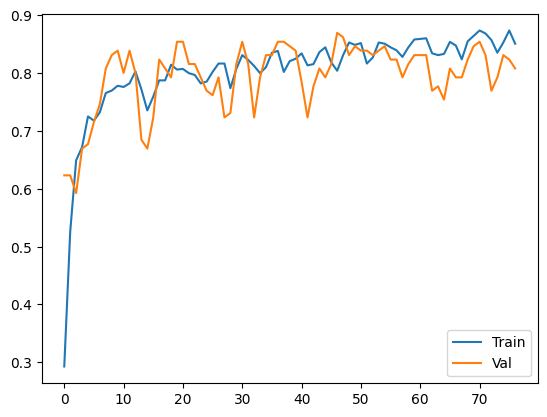

In [61]:
# Checking the overfitting
plt.plot(Hist_3.history['acc'], label='Train')
plt.plot(Hist_3.history['val_acc'], label='Val')
plt.legend()
plt.show()

In [62]:
# Evaluate with test
Model_3.evaluate(dt_test, y_test_onehot)

5/5 [==============================] - 0s 3ms/step - loss: 0.5466 - acc: 0.8308


[0.5465972423553467, 0.8307692408561707]

With Early Stopping, it was possible to get a better accuracy and less error and to avoid overtraining.

Now, let's compare the model with a simple logistic regression.

In [67]:
y_train_onehot

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [68]:
# The logistic regression
classifier = LogisticRegression(multi_class='multinomial').fit(dt_train, y_Train_bal)
y_train_logistic =  classifier.predict(dt_train)
y_test_logistic =  classifier.predict(dt_test)

# R2 score
acc_train = metrics.accuracy_score(y_Train_bal, y_train_logistic)
acc_test = metrics.accuracy_score(y_test, y_test_logistic)

# Print the results
print("The accuracy for training is: ", acc_train)
print("The accuracy for testing is: ", acc_test)

The accuracy for training is:  0.7871235721703012
The accuracy for testing is:  0.8153846153846154


In this cases. As I got with the linear regression, the ANN has had a better representation of the multiclassification than the machine learning model. But, I haven't tuned the logistic one and the ANN one, yet.

Now Let's try Keras_tuner to improve the best ANN

In [69]:
1e-2

0.01

In [76]:
def model_builder(hp):

  # Hyper-Parameters
  neurons_init_hp = hp.Int(name = 'start_neurons', min_value = 32, max_value = 512, step = 64)
  neurons_hp = hp.Choice('units', values = [64, 128, 256])
  optimizer_hp = hp.Choice('optimizer', values = ['RMSprop', 'Adam', 'SGD'])
  activation_hp = hp.Choice(name = 'activation', values = ['elu', 'selu', 'relu'])
  lambda_regularizer_hp = hp.Choice('lambda_regularizer', values = [1e-4, 1e-2, 0.1])
  dropout_percentage_hp = hp.Choice('dropout_rate', values = [0.2, 0.4, 0.6])

  # Model Structure
  Model = Sequential()
  Model.add(Dense(units=neurons_init_hp, activation=activation_hp, input_shape=(4,), kernel_regularizer=regularizers.l2(lambda_regularizer_hp)))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dropout(dropout_percentage_hp))
  Model.add(Dense(units=neurons_hp, activation=activation_hp, kernel_regularizer=regularizers.l2(lambda_regularizer_hp)))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dropout(dropout_percentage_hp))
  Model.add(Dense(4, activation='softmax'))

  # Compile and Train the model
  Model.compile(optimizer=optimizer_hp, loss='categorical_crossentropy', metrics=['acc'])

  return Model

In [77]:
# The searcher
tuner = kt.Hyperband( 
    model_builder,
    objective = "val_acc",
    max_epochs = 200,
    factor = 3, 
    directory = "out/",
    project_name = "classifier-tunner" 
)

INFO:tensorflow:Reloading Oracle from existing project out/classifier-tunner\oracle.json
INFO:tensorflow:Reloading Tuner from out/classifier-tunner\tuner0.json


In [79]:
# The Auto Keras part
tuner.search(dt_train, y_train_onehot, epochs=200, validation_data=(dt_val, y_val_onehot))

Trial 42 Complete [00h 00m 05s]
val_acc: 0.8615384697914124

Best val_acc So Far: 0.8692307472229004
Total elapsed time: 00h 00m 51s
INFO:tensorflow:Oracle triggered exit


In [80]:
# Get the best hyperparamaters and model
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

# Evaluate the best model
acc_test_2 = best_model.evaluate(dt_test, y_test_onehot)
print("The accuracy for the tunned model is: ", acc_test_2)

5/5 [==============================] - 0s 3ms/step - loss: 3.3485 - acc: 0.8385
The accuracy for the tunned model is:  [3.348543882369995, 0.8384615182876587]


In [81]:
# Saved my model
best_model.save("out\ANN_classifier.h5")

Conclusion. It was possible to build a multi-classification Artificial Neural Network model. This doesn't mean it is alway the best way, but it shows the big power of Deep Learning as a complement of Machine Learning.